In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import savemat

In [6]:
vmin=520
vmax=600
gamma = 1.5
res_path = '/project/'  
dat_path = ''
scene_name = 'bunny'
gamma_diag = 2.2

In [7]:
def norm_im(im, blk, wht):
    im = (im - blk)/(wht - blk)
    im[im<0] = 0
    im[im>1] = 1
    return im

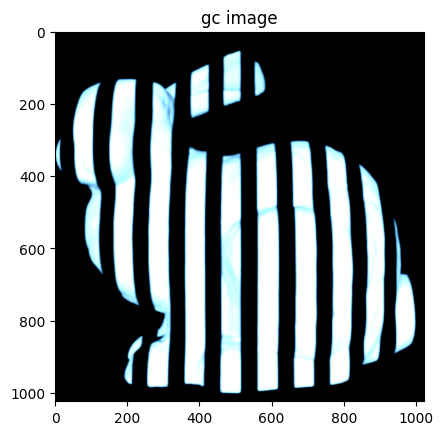

True

In [8]:
blk_lev = 0.065
wht_lev = 0.5
gamma_vis = 2.2
R = 1024
C = 1024

im_gc = 1*cv2.imread(os.path.join(dat_path, 'result_pattern_13.png'))/255
im_gc = cv2.resize(im_gc, (C,R))
im_gc_vis = norm_im(im_gc, blk_lev, wht_lev)
im_gc_vis = im_gc_vis**(1/gamma_vis)
plt.imshow(im_gc_vis[...,::-1])
plt.title('gc image')
plt.show()
cv2.imwrite(os.path.join(res_path, 'im_gc.png'), 256*(im_gc**(1/gamma_vis)))
cv2.imwrite('im_gc.png', 256*(im_gc_vis))

In [ ]:
def read_epi_gc(dat_path, prefix):
    N_gc = 40 # number of graycode images
    fsize = 3

    # load captured patterns
    cap_roi = []
    for i in range(N_gc):
        fn = os.path.join(dat_path, '%s_%02d.png'%(prefix, i))
        im_roi = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        im_roi = ndimage.median_filter(im_roi, size=fsize)
        cap_roi.append(im_roi)
        
    return cap_roi

def estimate_depth_graycode(roi, cap_roi):
    # parameters
    cam_shape = (360, 360) # row, column
    proj_shape = (360, 360) # row, column
    N_gc = 38 # number of graycode images
    N_tot = N_gc  # number of capture images (graycode + white + black)
    gc_step = 1 # should be 1 
    black_thr = 0
    white_thr = 0
    
    # captured patterns
    cap = []
    for cap_roi_i in cap_roi:
        im = np.zeros(cam_shape).astype(np.uint8)
        im[roi[0]:roi[1], roi[2]:roi[3]] = cap_roi_i
        cap.append(im)
        
    # prepare simulation patterns
    gc_height = int((proj_shape[0]-1)/gc_step)+1    
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)
    sim = graycode.generate()[1]
    sim_w = np.ones(proj_shape)
    sim_b = np.zeros(proj_shape)
    
    R,C = im.shape
    cap_w = cap[-2]
    cap_b = cap[-1]
    
    # estimate the correspondence map
    corr = np.zeros((cam_shape[0], cam_shape[1], 2))
    cam_pts = []
    prj_pts = []
    valid_mask = np.zeros(cam_shape)
    for r in range(cam_shape[0]):
        if r%400 == 0:
            print('decoding %.2f'%(r/cam_shape[0]))
        for c in range(cam_shape[1]):
            err, proj_pix = graycode.getProjPixel(cap, c, r)
            if not err:
                corr[r,c] = np.array(proj_pix)
                cam_pts.append((c,r))
                prj_pts.append((proj_pix[0],proj_pix[1]))
                valid_mask[r,c] = True
    
    # load the geometric calibration data
    camproj_calib_path = '/projects/FHEIDE/polar/captured_data_cam_prj/calibration_procam.xml'
    fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = fs.getNode("img_shape").mat()
    cam_int = fs.getNode("cam_int").mat() #focal length [[f, 0, cx], [0, f, cy], [0, 0, 1]]
    cam_dist = fs.getNode("cam_dist").mat() # [1, 0, 0, 0, 0]
    proj_int = fs.getNode("proj_int").mat()
    proj_dist = fs.getNode("proj_dist").mat()
    cam_proj_rmat = fs.getNode("rotation").mat()  # eye(4)
    cam_proj_tvec = fs.getNode("translation").mat()  # [1, 0, 0]
    F = fs.getNode("fundamental").mat()
    E = fs.getNode("epipolar").mat()
    
    # undistort points using calibration
    cam_pts = np.array(cam_pts, dtype=np.float32) 
    cam_pts = cam_pts.reshape((-1, 1, 2))
    cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
    prj_pts = np.array(prj_pts, dtype=np.float32) 
    prj_pts = prj_pts.reshape((-1, 1, 2))
    prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
    
    # triangulate
    P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0]]))
    P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
    triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
    points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()
    
    # xyz 
    cam_pts = cam_pts.astype(np.int)
    xyz = np.zeros((R,C,3))
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 0]=points_3d[:,0]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 1]=points_3d[:,1]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 2]=points_3d[:,2]
    xyz = xyz[roi[0]:roi[1], roi[2]:roi[3],:]
    
    return xyz